#STAT 548/CSE 547 Tutorial: Vectorization
### **Instructor**:</b> Marina Meila
### **TA**: Medha Agarwal
### **Date**: May 05, 2025

---

## ⏰ Previously...

We looked at use of different compute environments, methods for package management, and a standard ML pipeline for clustering on image data.

---

## 📘 Tutorial Overview

In this tutorial, we will study **Vectorization**. Vectorization is the process of converting scalar operations (loop-based) into array operations, enabling faster computation using low-level optimizations (like SIMD or BLAS under the hood). Python is an interpreted language, which means that each line of code is executed one at a time by the interpreter. This results in a significant overhead—especially for functions and loops—compared to compiled languages like C or C++, where code is translated into fast, machine-level instructions ahead of time. To avoid the performance hit from running many slow Python loops, programmers instead use vectorization: a strategy that leverages pre-compiled, highly optimized low-level functions (also called kernels)—often written in C or Fortran—to perform large-scale operations in a single step.

TL;DR:

- Loops are slow in Python due to interpreted execution.

- Vectorized operations run in compiled C.

- Vectorization minimizes overhead and memory access.

Later, we will look at an alternate definition of Vectorization.


Consider the simple example.


In [ ]:
import numpy as np
import time

a = np.random.rand(1000000)
b = np.random.rand(1000000)

# Elementwise additon

start = time.time()
c = [a[i] + b[i] for i in range(len(a))]  # slow
print(f"{'Loop:':<15}{time.time() - start}")

start = time.time()
c = a + b  # fast
print(f"{'Vectorized:':<15}{time.time() - start}")

Loop:          0.2502572536468506
Vectorized:    0.01661968231201172


#### **Why Are Python Loops Slow?**

1. **Python is interpreted**: Python executes code line by line using an interpreter (like CPython). Each operation (like `a + b`) involv.

2. **Dynamic typing**: Python figures out the type of each variable *at runtime*, which slows down simple operations compared to compiled languages like C, where types are known ahead of time.

3. **No CPU-level optimization**:In Python loops, each iteration is a high-level Python operation. The interpreter can't take advantage of low-level CPU optimizations like SIMD (single instruction, multiple data) or pipelining.

4. **Function call overhead**: Calling a function in Python involves building a call stack, managing arguments, and more—this adds up inside loops.


#### **What Is Vectorization Fast?**

1. **Pre-compiled code**: Libraries like NumPy use C or Fortran code under the hood. These libraries are compiled once into machine code and linked into Python. They are extremely fast.

2. **Vectorization**: Instead of looping in Python, you send an entire array or matrix to a **compiled function** (a kernel). The compiled function runs at C-speed, using optimized operations (SIMD, multi-threading, BLAS, etc.).


In [ ]:
# Elementwise multiplication

start = time.time()
c = [a[i] * b[i] for i in range(len(a))]  # slow
print(f"{'Loop:':<15}{time.time() - start}")

start = time.time()
c = np.dot(a, b)  # fast
print(f"{'Vectorized:':<15}{time.time() - start}")

Loop:          0.30338430404663086
Vectorized:    0.020466089248657227


In [ ]:
# Applying a function

def taxed_price(price, tax_rate, discount):
    return (price * (1 + tax_rate)) - discount

prices = np.random.randn(10000)
tax_rate = 0.1
discount = 15

# loop
start = time.time()
results = np.array([
    taxed_price(p, tax_rate, discount) for p in prices
])
print(f"{'Loop:':<15}{time.time() - start}")

# using np.vectorize
start = time.time()
vectorized_taxed_price = np.vectorize(taxed_price)
results = vectorized_taxed_price(prices, tax_rate=0.1, discount=15)
print(f"{'np.vectorize:':<15}{time.time() - start}")

# broadcasting
start = time.time()
results = taxed_price(prices, tax_rate=0.1, discount=15)
print(f"{'Vectorized:':<15}{time.time() - start}")


Loop:          0.009400367736816406
np.vectorize:  0.02224111557006836
Vectorized:    0.0001857280731201172


Broadcasting is a set of rules that NumPy uses to perform element-wise operations on arrays of different shapes.
Instead of explicitly copying or reshaping arrays to match in size, NumPy "broadcasts" the smaller array across the larger one as if it were replicated to match dimensions.

In [ ]:
import numpy as np

a = np.array([1, 2, 3])
b = 10
a + b  # [11, 12, 13]


array([11, 12, 13])


Given:

* A matrix `A` of shape `(m, n)`
* A vector `x` of shape `(n,)`

Compute the product `y = A @ x`, which results in a vector of shape `(m,)`.


In [ ]:
A = np.random.rand(1000, 1000)
x = np.random.rand(1000)

# Loop-based matrix-vector multiplication
start = time.time()
y_loop = np.zeros(A.shape[0])
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        y_loop[i] += A[i, j] * x[j]
print(f"{'Loop:':<15}{time.time() - start}")

start = time.time()
y_vec = A @ x
print(f"{'Vectorized:':<15}{time.time() - start}")


Loop:          1.0335450172424316
Vectorized:    0.0013082027435302734


Given:
- `A` is set of `n` vectors of dimension `d`, shape `(n,d)`
- `B` is set of `n` vectors of dimension `d`, shape `(n,d)`

Compute the Euclidean distance between points in `A` and `B`.

In [ ]:
A = np.random.rand(1000, 3)
B = np.random.rand(1000, 3)

distances_loop = np.zeros(A.shape[0])
start = time.time()
for i in range(A.shape[0]):
    diff = A[i] - B[i]
    distances_loop[i] = np.sqrt(np.sum(diff ** 2))
print(f"{'Loop:':<15}{time.time() - start}")

start = time.time()
distance_vec = np.linalg.norm(A-B)
print(f"{'Vectorized:':<15}{time.time() - start}")


Loop:          0.00885915756225586
Vectorized:    0.0007104873657226562


#### Batch Gradient Descent for Logistic Regression

Given:

* Data matrix $X \in \mathbb{R}^{n \times d}$
* Labels $y \in \{0, 1\}^n$
* Weights $w \in \mathbb{R}^d$

The **logistic function**:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

**Loss**: Binary cross-entropy

**Gradient**:

$$
\nabla_w = \frac{1}{n} X^T (\sigma(Xw) - y)
$$


In [ ]:
import numpy as np

# Generate random dataset
np.random.seed(0)
n_samples, n_features = 1000, 10
X = np.random.randn(n_samples, n_features)
true_w = np.random.randn(n_features)
y_prob = 1 / (1 + np.exp(-X @ true_w))
y = (y_prob > 0.5).astype(float)  # Binary labels

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


In [ ]:
# Loop-based gradient descent
w_loop = np.zeros(n_features)
lr = 0.1
epochs = 100

start = time.time()
for epoch in range(epochs):
    gradient = np.zeros(n_features)
    for i in range(n_samples):
        z = np.dot(X[i], w_loop)
        pred = sigmoid(z)
        error = pred - y[i]
        for j in range(n_features):
            gradient[j] += error * X[i, j]
    gradient /= n_samples
    w_loop -= lr * gradient
print(f"{'Loop:':<15}{time.time() - start}")

# Vectorized gradient descent
w_vec = np.zeros(n_features)

start = time.time()
for epoch in range(epochs):
    z = X @ w_vec
    pred = sigmoid(z)
    error = pred - y
    gradient = X.T @ error / n_samples
    w_vec -= lr * gradient
print(f"{'Vectorized:':<15}{time.time() - start}")


Loop:          1.1489245891571045
Vectorized:    0.008505582809448242


In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Simulated binary classification dataset
np.random.seed(0)
n_samples, d, h = 1000, 10, 32
X_np = np.random.randn(n_samples, d)
y_np = (np.random.rand(n_samples) > 0.5).astype(np.float32)

# Sigmoid and ReLU
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def relu_grad(z):
    return (z > 0).astype(np.float32)


In [ ]:
# Initialize weights
W1 = np.random.randn(d, h) * 0.01
b1 = np.zeros(h)
W2 = np.random.randn(h, 1) * 0.01
b2 = np.zeros(1)
lr = 0.1

start = time.time()
for epoch in tqdm(range(10)):
    # Forward
    Z1 = np.zeros((n_samples, h))
    A1 = np.zeros((n_samples, h))
    for i in range(n_samples):
        for j in range(h):
            Z1[i, j] = np.dot(X_np[i], W1[:, j]) + b1[j]
            A1[i, j] = relu(Z1[i, j])

    Z2 = np.zeros(n_samples)
    A2 = np.zeros(n_samples)
    for i in range(n_samples):
        Z2[i] = np.dot(A1[i], W2[:, 0]) + b2[0]
        A2[i] = sigmoid(Z2[i])

    # Loss (binary cross-entropy)
    loss = -np.mean(y_np * np.log(A2 + 1e-8) + (1 - y_np) * np.log(1 - A2 + 1e-8))

    # Backward pass
    dZ2 = A2 - y_np  # shape (n_samples,)
    dW2 = np.zeros_like(W2)
    db2 = np.sum(dZ2) / n_samples

    for j in range(h):
        for i in range(n_samples):
            dW2[j] += dZ2[i] * A1[i, j]
    dW2 /= n_samples

    dA1 = np.dot(dZ2.reshape(-1, 1), W2.T)  # shape (n_samples, h)
    dZ1 = dA1 * relu_grad(Z1)
    dW1 = np.zeros_like(W1)
    db1 = np.zeros_like(b1)

    for j in range(h):
        for k in range(d):
            for i in range(n_samples):
                dW1[k, j] += dZ1[i, j] * X_np[i, k]
        dW1[:, j] /= n_samples
        db1[j] = np.sum(dZ1[:, j]) / n_samples

    # Update
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2

print("")
print(f"{'Loop:':<15}{time.time() - start}")


100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


Loop:          6.712578296661377


In [ ]:
# Convert to PyTorch
X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.float32).view(-1, 1)

W1 = torch.randn(d, h, requires_grad=True)
b1 = torch.zeros(h, requires_grad=True)
W2 = torch.randn(h, 1, requires_grad=True)
b2 = torch.zeros(1, requires_grad=True)
lr = 0.1

start = time.time()
for epoch in tqdm(range(10)):
    # Forward
    Z1 = X @ W1 + b1
    A1 = F.relu(Z1)
    Z2 = A1 @ W2 + b2
    loss = F.binary_cross_entropy_with_logits(Z2, y)

    # Backward
    loss.backward()

    # Gradient descent
    with torch.no_grad():
        W1 -= lr * W1.grad
        b1 -= lr * b1.grad
        W2 -= lr * W2.grad
        b2 -= lr * b2.grad
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()

print("")
print(f"{'Vectorized and autodiff:':<20}{time.time() - start}")


100%|██████████| 10/10 [00:00<00:00, 1030.85it/s]


Vectorized and autodiff:0.013457298278808594


## Vectorization - another definition

Vectorization is jargon for a classic approach of converting input data from its raw format (i.e. text ) into vectors of real numbers which is the format that ML models support. This approach has been there ever since computers were first built, it has worked wonderfully across various domains, and it’s now used in NLP.

In Machine Learning, vectorization is a step in feature extraction. The idea is to get some distinct features out of the text for the model to train on, by converting text to numerical vectors.

*Source: [Neptune AI blog](https://neptune.ai/blog/vectorization-techniques-in-nlp-guide#:~:text=In%20Machine%20Learning%2C%20vectorization%20is,converting%20text%20to%20numerical%20vectors.)*

### 1. One-Hot Encoding and Bag-of-Words (BoW)

* Vocabulary size $V$
* Represent a word $w_i \in V$ as a vector $\vec{e}_i \in \mathbb{R}^V$
* BoW: count vector over a document

**Limitations**:

* Ignores word order (syntax/semantics)
* Sparse and memory inefficient


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = ["NLP is fun", "Vectorization is essential in NLP"]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names_out())
print(X.toarray())

['essential' 'fun' 'in' 'is' 'nlp' 'vectorization']
[[0 1 0 1 1 0]
 [1 0 1 1 1 1]]




### 2. TF-IDF

TF-IDF or Term Frequency–Inverse Document Frequency, is a numerical statistic that’s intended to reflect how important a word is to a document. Although it’s another frequency-based method, it’s not as naive as Bag of Words.
Absolutely! Let's break down the formula for **TF-IDF**—**Term Frequency-Inverse Document Frequency**—which is a way to weigh how important a word is to a document in a collection (corpus).


For a term $t$ in a document $d$, within a corpus $D$:

$$
\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$

TF measures **how frequently a term appears in a document**.

$$
\text{TF}(t, d) = \frac{\text{Number of times } t \text{ appears in } d}{\text{Total number of terms in } d}
$$

IDF **how unique or rare a term is across all documents**.

$$
\text{IDF}(t, D) = \log\left(\frac{N}{1 + \text{DF}(t)}\right)
$$

Where:

* $N$ = total number of documents

* $\text{DF}(t)$ = number of documents containing the term $t$


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(X.toarray())

[[0.         0.70490949 0.         0.50154891 0.50154891 0.        ]
 [0.49922133 0.         0.49922133 0.35520009 0.35520009 0.49922133]]



### 3. Word2Vec

This approach uses the power of a simple Neural Network to generate word embeddings.

How does Word2Vec improve over frequency-based methods?

In Bag of Words and TF-IDF, we saw how every word was treated as an individual entity, and semantics were completely ignored. With the introduction of Word2Vec, the vector representation of words was said to be contextually aware, probably for the first time ever.

Perhaps, one of the most famous examples of Word2Vec is the following expression:

```king – man + woman = queen```

Since every word is represented as an n-dimensional vector, one can imagine that all of the words are mapped to this n-dimensional space in such a manner that words having similar meanings exist in close proximity to one another in this hyperspace.

There are mainly two ways to implement Word2Vec, let’s take a look at them one by one:

  * Skip-gram
  * CBOW

Let us understand one of them.

**Skip-Gram**: The first one is the Skip-Gram method in which we provide a word to our Neural Network and ask it to predict the context. The general idea can be captured with the help of the following image:
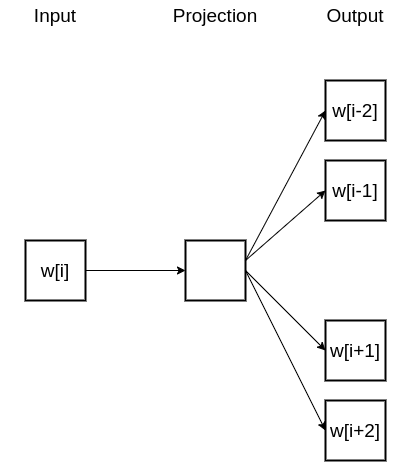

Here `w[i]` is the input word at an `i` location in the sentence, and the output contains two preceding words and two succeeding words with respect to `i`.

Technically, it predicts the probabilities of a word being a context word for the given target word. The output probabilities coming out of the network will tell us how likely it is to find each vocabulary word near our input word.
This shallow network comprises an input layer, a single hidden layer, and an output layer, we’ll take a look at that shortly.

How many neighboring words the network is going to predict is determined by a parameter called “window size”. This window extends in both the directions of the word, i.e. to its left and right.

Let’s say we want to train a skip-gram word2vec model over an input sentence:

“The quick brown fox jumps over the lazy dog”

The following image illustrates the training samples that would generate from this sentence with a window size = 2.

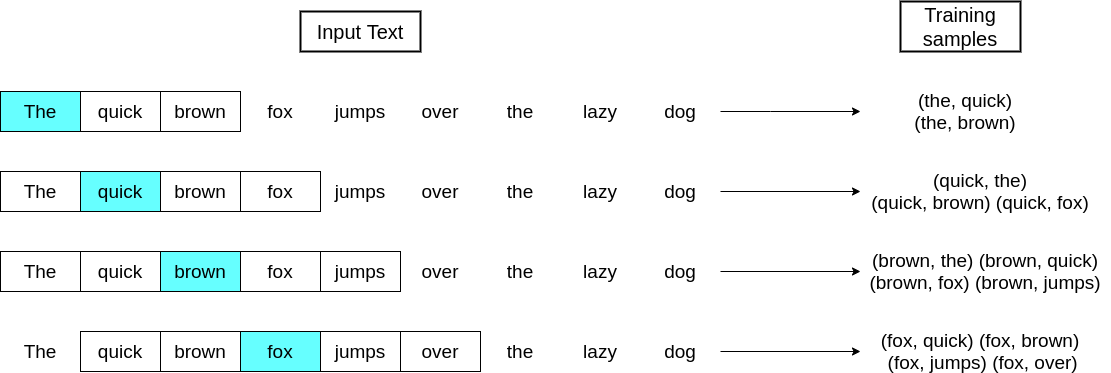

Vectorization techniques - w2v_window
‘The’ becomes the first target word and since it’s the first word of the sentence, there are no words to its left, so the window of size 2 only extends to its right resulting in the listed training samples.
As our target shifts to the next word, the window expands by 1 on left because of the presence of a word on the left of the target.
Finally, when the target word is somewhere in the middle, training samples get generated as intended.

**Goal**: Learn a vector for each word based on its context using a shallow neural network.

#### Skip-gram Objective:

Given a center word $w_t$, predict surrounding context words $w_{t \pm k}$:

$$
\max \sum_{t=1}^{T} \sum_{-k \leq j \leq k, j \neq 0} \log P(w_{t+j} \mid w_t)
$$

Where:

* $P(w_{context} \mid w_{center}) = \frac{\exp(v_{context}^\top v_{center})}{\sum_{w'} \exp(v_{w'}^\top v_{center})}$
* $v_w$: learned embedding of word $w$

These are **static embeddings**: each word has a fixed vector regardless of context.



In [ ]:
from gensim.models import Word2Vec

# Example training data (small toy corpus)
sentences = [
    ["king", "queen", "man", "woman"],
    ["paris", "france", "rome", "italy"],
    ["apple", "orange", "banana", "fruit"]
]

# Train Word2Vec model
model = Word2Vec(sentences, vector_size=50, window=2, min_count=1, sg=1)

# Show most similar words to 'king' based on cosine similarity
similar_words = model.wv.most_similar("king", topn=5)

print("Nearest neighbors to 'king':")
for word, similarity in similar_words:
    print(f"{word} : {similarity:.4f}")




### 6. Transformer Embeddings (BERT)

These are contextual embeddings using attention over entire input.


#### a. **Input Representation**

Each token in a sentence is converted to a vector:

$$
\mathbf{x}_i = \text{TokenEmbedding}(w_i) + \text{PositionEmbedding}(i)
$$

Where:

* $w_i$: the $i$-th token (word/piece)
* $\mathbf{x}_i \in \mathbb{R}^d$: input embedding vector
* $d$: embedding dimension


#### b. **Self-Attention**

Each input vector $\mathbf{x}_i$ is passed through multiple Transformer layers. At each layer, self-attention computes:

$$
\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{d_k}}\right)\mathbf{V}
$$

Where for each token:

* $\mathbf{Q}_i = \mathbf{W}^Q \mathbf{x}_i$
* $\mathbf{K}_i = \mathbf{W}^K \mathbf{x}_i$
* $\mathbf{V}_i = \mathbf{W}^V \mathbf{x}_i$

And $\mathbf{W}^Q, \mathbf{W}^K, \mathbf{W}^V$ are learned matrices.

The result is a context-aware embedding $\mathbf{h}_i^{(L)} \in \mathbb{R}^d$ after $L$ layers.


#### c. **Transformer Layer**:

Multiple self-attention heads + feedforward layers:

$$
\text{Output}_i = \text{LayerNorm}(x_i + \text{FFN}(\text{SelfAttention}(x)))
$$

Stacking many such layers, BERT produces final embeddings $\mathbf{h}_i^{(L)}$ for each word:

$$
\mathbf{h}_1^{(L)}, \dots, \mathbf{h}_n^{(L)}
$$

These capture the **meaning of each token in its sentence context**.





In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

inputs = tokenizer("NLP is cool", return_tensors="pt")
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)  # [1, tokens, 768]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

torch.Size([1, 6, 768])


In [ ]:
inputs['input_ids'].shape

torch.Size([1, 6])

In [ ]:
outputs.last_hidden_state

tensor([[[-0.2110, -0.0889,  0.0351,  ..., -0.0911,  0.1138,  0.5107],
         [ 0.2817, -0.8713,  0.4425,  ...,  0.0023,  1.0667,  0.3444],
         [-0.1729, -0.4737,  0.2838,  ..., -0.0377, -0.2720,  0.1855],
         [-0.2438, -0.6063,  0.2243,  ...,  0.2999,  0.2081,  0.8959],
         [-0.0240, -1.1882,  0.2612,  ...,  0.6657,  0.1180,  0.0661],
         [ 0.7557, -0.0592, -0.2365,  ...,  0.4078, -0.8266, -0.1610]]],
       grad_fn=<NativeLayerNormBackward0>)

### Comparison: BERT vs Word2Vec

| Feature                | **Word2Vec**                          | **BERT (Transformer)**                    |
| ---------------------- | ------------------------------------- | ----------------------------------------- |
| **Context**            | Static (one embedding per word)       | Contextual (depends on sentence)          |
| **Training Objective** | Predict context words (CBOW/SkipGram) | Masked Language Modeling (MLM)            |
| **Model Type**         | Shallow NN                            | Deep Transformer (multi-layer)            |
| **Directionality**     | Unidirectional or windowed            | Bidirectional (sees full sentence)        |
| **Embeddings**         | One fixed vector per word             | Dynamic vector per word **per sentence**  |
| **Mathematical Depth** | Dot products, shallow loss            | Attention, positional encoding, deep nets |

---

### Example:

| Sentence                   | Word   | Word2Vec Embedding      | BERT Embedding                          |
| -------------------------- | ------ | ----------------------- | --------------------------------------- |
| "He sat on the **bank**."  | `bank` | Same as in all contexts | Embedding reflects "river bank" meaning |
| "She works at a **bank**." | `bank` | Same                    | Embedding reflects "financial bank"     |
